# Stacked LSTMs with Memory Between Batches
# Stacked LSTM for Mauna Loa Atmospheric CO2 Concentration with memory

## Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


2024-03-04 20:02:25.608030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define a function to convert an array of values into a dataset matrix

In [5]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

## Load the dataset

In [2]:
fnam='https://raw.githubusercontent.com/SiuSunChun/2024LearningLSTM/main/co2.csv?raw=true'
dataframe = read_csv(fnam, usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')


## Look at the data

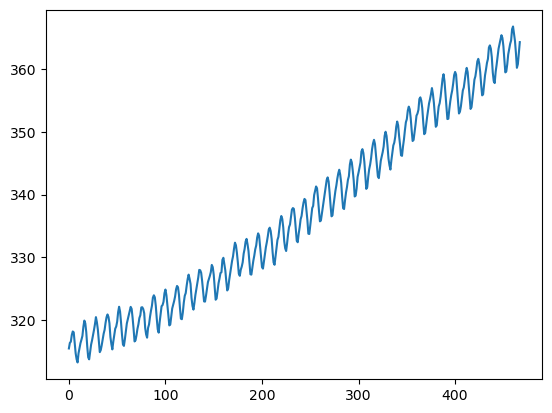

In [3]:
plt.plot(dataset)
plt.show()

## Preprocess the data to be model input

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


## Set up and fit the LSTM model

In [7]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Fix random seed for reproducibility
tf.random.set_seed(20240304)
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()


2024-03-04 20:03:40.444501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


309/309 - 4s - loss: 0.0024 - 4s/epoch - 14ms/step
309/309 - 2s - loss: 0.0035 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0032 - 2s/epoch - 5ms/step
309/309 - 1s - loss: 0.0029 - 1s/epoch - 5ms/step
309/309 - 2s - loss: 0.0028 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0027 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0026 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0026 - 2s/epoch - 6ms/step
309/309 - 2s - loss: 0.0025 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0024 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0023 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0021 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0018 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0024 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0016 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0014 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0013 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0016 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0013 - 2s/epoch - 5ms/step
309/309 - 2s - loss: 0.0011 - 2s/epoch - 5ms/step

## Evaluate performance

In [8]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


151/151 [==============================] - 0s 2ms/step
Train Score: 0.04 RMSE
Test Score: 0.08 RMSE


## Plot the evaluation results 

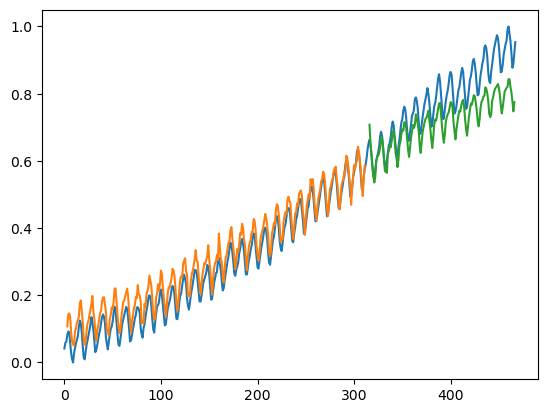

In [9]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()